# Телекоммуникации

#### Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг
##### Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
##### Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
##### За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


##### Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.
##### Во всех файлах столбец customerID содержит код клиента.

# План проекта

##### 1. Подготовка данных:
* Импорт библиотек
* Объединение таблиц
* Проверка данных на пропуски и дубликаты
* Изучение общей информации о датасете
##### 2. Предобработка данных:
* Замена пропусков
* Проверка данны на дубликаты
* Добавление столбцов с количеством дней, месяцев и целевого признака
* Вывод
##### 3. Анализ данных:
* Построение тепловой карты для визуализации корреляции признаков
* Визуализация корреляции признаков относительно целевого
* Построение гистограм для поиска закономерностей оттока клиентов
* Вывод
##### 4. Машинное обучение:
* Убрать из обучающей выборки лишние признаки
* Определить целевой признак
* Поделить тренировочную и тестовую выборки в соотношении 1 : 3
* Стандартизировать данные
* Рассмотреть несколько моделей на кросс-валидации
* Выбрать лучшую модель
* Подобрать гиперпараметры
* Проверить модель на тестовой выборке
* Посмотреть значимость признаков
* Вывод
##### 5. Отчёт

#### В процессе выполнения проекта возникло несколько вопросов:
* стоит ли объединять все таблицы в одну?
* корректно ли будет заменить пропущенные значения на 0?
* как лучше определить целевой признак?
* корректно ли кодировать категориальные данные в процессе анализа или сделать это перед машинным обучением?
* корректно ли заменить дату окончания договора на 1 февраля 2020 года там, где договор ещё действует или оставить данный столбец без изменений?

# Подготовка и предобработка данных
* Импорт библиотек
* Объединение таблиц
* Проверка данных на пропуски и дубликаты
* Изучение общей информации о датасете
* Замена пропусков
* Добавление столбцов с количеством дней, месяцев и целевого признака
* Вывод

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik import phik_matrix
import shap
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
file_paths_y = ['/datasets/contract_new.csv', '/datasets/personal_new.csv', '/datasets/internet_new.csv', '/datasets/phone_new.csv']
file_paths = ['contract_new.csv', 'personal_new.csv', 'internet_new.csv', 'phone_new.csv']
data_frames = []

try:
    data_frames = [pd.read_csv(file) for file in file_paths]
    data = data_frames[0]
    for df in data_frames[1:]:
        data = data.merge(df, on='customerID', how='outer')

    data.to_csv('combined_data.csv', index=False)
    
except:
    data_frames = [pd.read_csv(file) for file in file_paths_y]
    data = data_frames[0]
    for df in data_frames[1:]:
        data = data.merge(df, on='customerID', how='outer')

    data.to_csv('combined_data.csv', index=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [4]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [5]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [6]:
data = data.fillna('No')

In [7]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


##### В датасете требуется:   
* Убрать пропуски 
* Применить One Hot Encoding для кодирования категориальных признаков  
* Привести столбец TotalCharges к типу данных float
* Определить целевой признак
* Создать столбцы с количеством дней и месяцев пользования услугами

In [8]:
# Заменяем значение 0 в столбце EndDate на None
data['EndDate'] = data['EndDate'].replace('No', None)

# Преобразуем столбцы BeginDate и EndDate в тип данных datetime
data['BeginDate'] = pd.to_datetime(data['BeginDate'])
data['EndDate'] = pd.to_datetime(data['EndDate'])

# Заменяем значения None на дату 1 февраля 2020 года
data['EndDate'] = data['EndDate'].fillna(pd.to_datetime('2020-02-01'))

In [9]:
# Создаем новый столбец DurationDays с разницей в днях между EndDate и BeginDate
data['DurationDays'] = (data['EndDate'] - data['BeginDate']).dt.days.astype(int)
data['DurationMonth'] = round(data['DurationDays'] / 30).astype(int)

In [10]:
# Создаем новый столбец Leave с условием: если EndDate = 1 февраля 2020 года, в столбце Leave оставляем 0, 
# в ином случае пишем 1
data['Leave'] = np.where((data['DurationDays'] == 0) | (data['EndDate'] == pd.to_datetime('2020-02-01')), 0, 1)

In [11]:
# Приводим столбец TotalCharges с цифровому формату
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
for i in range(len(data)):
    if pd.isna(data['TotalCharges'][i]):
        data.at[i, 'TotalCharges'] = data['DurationMonth'][i] * data['MonthlyCharges'][i]

In [12]:
data[['MonthlyCharges', 'TotalCharges', 'DurationDays', 'DurationMonth']].describe()

,MonthlyCharges,TotalCharges,DurationDays,DurationMonth
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,898.555729,29.896209
std,30.090047,2112.742814,683.130510,22.874158
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,276.000000,9.000000
50%,70.350000,1343.350000,761.000000,25.000000
75%,89.850000,3236.690000,1461.000000,49.000000
max,118.750000,9221.380000,2314.000000,77.000000


In [13]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,DurationDays,DurationMonth,Leave
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,Yes,No,No,No,No,No,31,1,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,Yes,No,Yes,No,No,No,No,1036,35,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,Yes,Yes,No,No,No,No,No,123,4,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,Yes,No,Yes,Yes,No,No,No,1371,46,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,No,No,No,No,No,No,153,5,0


In [14]:
data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
DurationDays        0
DurationMonth       0
Leave               0
dtype: int64

In [15]:
data.duplicated().sum()

0

#### Выод:
* Явных дубликатов не обнаружено 
* Пропуски заменены на 'No'
* Добавлены новые столбцы: количество дней, месяцев
* Определён целевой признак - 'Leave'
* Категориальные признаки заменены на числовые

# Исследовательский анализ
* Построение тепловой карты для визуализации корреляции признаков
* Визуализация корреляции признаков относительно целевого
* Построение гистограм для поиска закономерностей оттока клиентов
* Вывод

In [16]:
# Исключаем столбцы customerID, BeginDate, EndDate из анализа
columns_to_exclude = ['customerID', 'BeginDate', 'EndDate']
interval_columns = ['MonthlyCharges', 'TotalCharges', 'DurationDays', 'DurationMonth', 'Leave']
phik_corr_matrix = phik_matrix(data.drop(columns=columns_to_exclude), interval_cols=interval_columns)

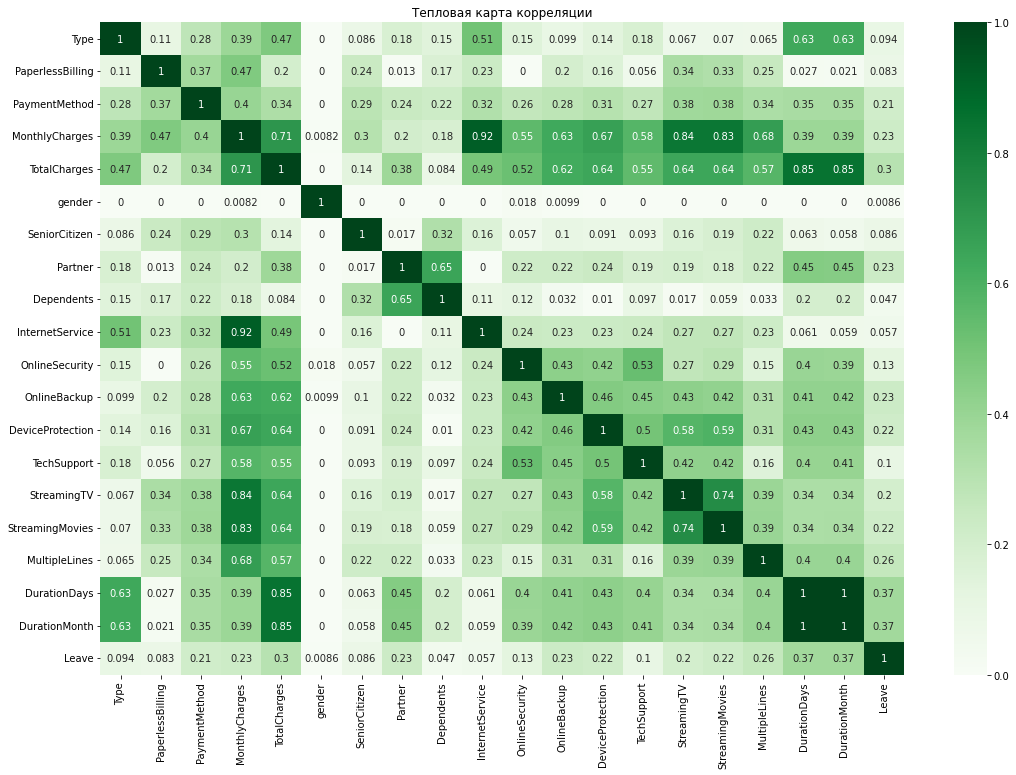

In [17]:
plt.figure(figsize=(18, 12))
sns.heatmap(phik_corr_matrix, annot=True, cmap='Greens')
plt.title('Тепловая карта корреляции');

In [18]:
columns_to_exclude = ['customerID', 'BeginDate', 'EndDate']
interval_columns = ['MonthlyCharges', 'TotalCharges', 'DurationDays', 'DurationMonth', 'Leave']
data_without_excluded = data.drop(columns=columns_to_exclude)

# Вычисляем PHIK корреляцию между Leave и другими признаками
leave_phik_corr = phik_matrix(data_without_excluded, interval_cols=interval_columns)['Leave'].sort_values(ascending=False)
leave_phik_corr

Leave               1.000000
DurationDays        0.374569
DurationMonth       0.373983
TotalCharges        0.302890
MultipleLines       0.261237
OnlineBackup        0.229482
Partner             0.226688
MonthlyCharges      0.226280
StreamingMovies     0.222232
DeviceProtection    0.218380
PaymentMethod       0.214832
StreamingTV         0.200198
OnlineSecurity      0.132594
TechSupport         0.103652
Type                0.094015
SeniorCitizen       0.086159
PaperlessBilling    0.083398
InternetService     0.056621
Dependents          0.046871
gender              0.008581
Name: Leave, dtype: float64

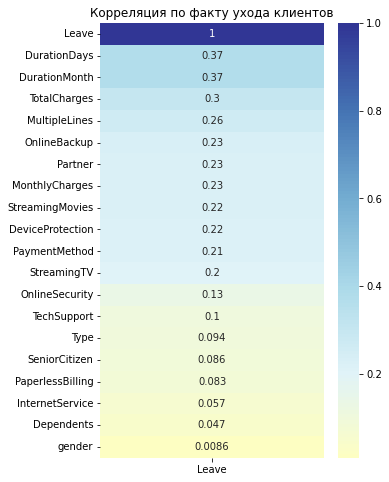

In [19]:
phik_corr_matrix = phik.phik_matrix(data_without_excluded, interval_cols=interval_columns)

# Отображение тепловой карты
plt.figure(figsize=(5, 8))
sorted_corr_with_leave = phik_corr_matrix[['Leave']].sort_values(by='Leave', ascending=False)
sns.heatmap(sorted_corr_with_leave, annot=True, cmap='RdYlBu', center=0)
plt.title('Корреляция по факту ухода клиентов')
plt.show()

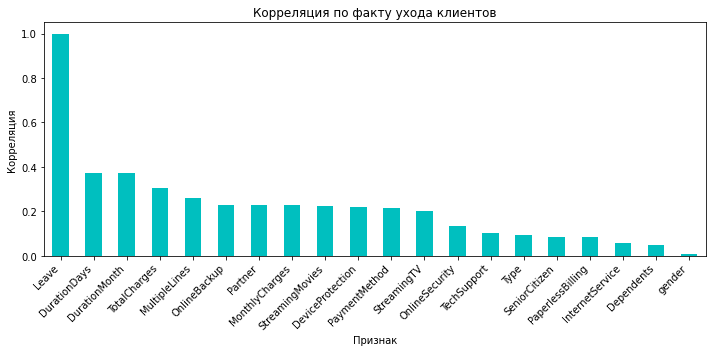

In [20]:
plt.figure(figsize=(10, 5))
leave_phik_corr.plot(kind='bar', color='c')
plt.title('Корреляция по факту ухода клиентов')
plt.xlabel('Признак')
plt.ylabel('Корреляция')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Построим гистограммы по некоторым признакам с целью определения закомерностей

In [21]:
def plot_histogram_with_leave(data, column): # определяем функцию для построения гистограм
    leave_0 = data[data['Leave'] == 0][column]
    leave_1 = data[data['Leave'] == 1][column]

    plt.figure(figsize=(12, 5))
    sns.histplot(leave_0, kde=True, color='blue', label='Leave=0', bins=80)
    sns.histplot(leave_1, kde=True, color='red', label='Leave=1', bins=80)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'{column} Histogram with Leave')
    plt.ylim(0, 300)
    plt.legend()
    plt.show()

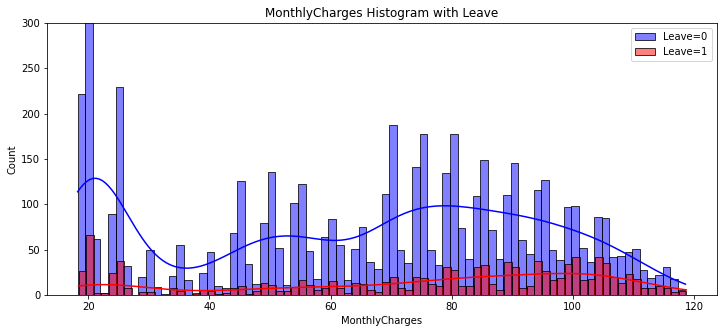

In [22]:
plot_histogram_with_leave(data, 'MonthlyCharges')

Вывод: чем выше ежемесячная плата, чем больше клиентов уходит

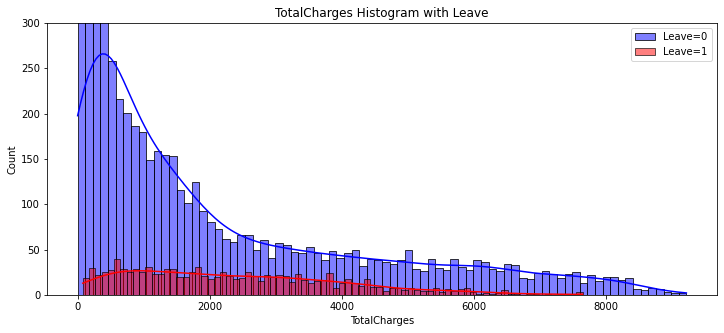

In [23]:
plot_histogram_with_leave(data, 'TotalCharges')

Чем больше клиент суммарно потратил денег на услуги, чем меньше вероятность ухода

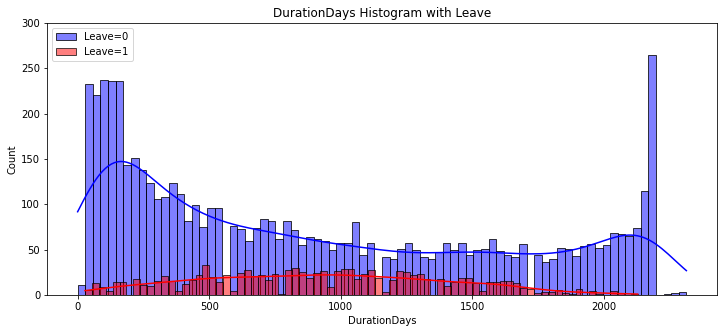

In [24]:
plot_histogram_with_leave(data, 'DurationDays')

Больше всего уходов клиентов в районе 500 - 1500 дней, что соответствует середине гистограммы

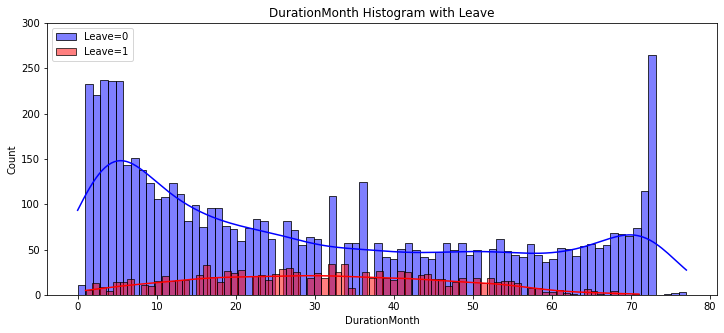

In [25]:
plot_histogram_with_leave(data, 'DurationMonth')

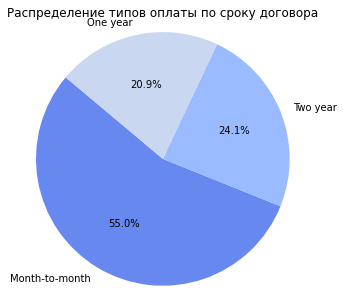

In [26]:
type_counts = data['Type'].value_counts()
new_palette = sns.color_palette('coolwarm')

plt.figure(figsize=(5, 5))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=new_palette)
plt.axis('equal')  # Это делает круг кругом, а не овалом
plt.title('Распределение типов оплаты по сроку договора')
plt.show()

#### Вывод:
* Самыми коррелирующими признаками оказались DurationDays(0.37), DurationMonth(0.37) и TotalCharges(0.3)
* Чем выше ежемесячная плата, чем больше клиентов уходит
* Чем больше клиент суммарно потратил денег на услуги, чем меньше вероятность ухода
* Больше всего уходов клиентов в районе 500 - 1500 дней, что соответствует середине гистограммы
* Чаще всего клиенты выбирают ежемесячную оплату, реже заключают договор на 2 года и на 1 год

# Машинное обучение

* Перекодируем категориальные признаки при помощи OHE
* Стандартизируем данные
* Уберём из обучающей выборки признаки: id клиента, даты начала и конца пользования услугами, наличие пенсионного статуса, интернет-сервисы, пол, наличие иждивенцев, безналичный расчет и целевой признак
* Определим целевой признак
* Поделим тренировочную и тестовую выборки в соотношении 1 : 3
* Стандартизируем данные
* Рассмотрим несколько моделей на кросс-валидации
* Выберем лучшую модель
* Подберём гиперпараметры
* Проверим её на тестовой выборке
* Посмотрим значимость признаков
* Сделаем выводы

In [27]:
# Уберем признаки, минимально коррелирующие с целевым
data = data.drop(['BeginDate', 'EndDate', 'customerID', 'SeniorCitizen', 'PaperlessBilling', 
                      'InternetService', 'Dependents', 'gender'], axis=1)

In [28]:
cat_features = ['Type', 'PaymentMethod', 'Partner', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'] # определим категориальные признаки

In [29]:
features = data.drop(['Leave'], axis=1)
target = data['Leave']

In [30]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=310723)

In [31]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(data[cat_features])

In [32]:
encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_features))

In [33]:
data_encoded = pd.concat([data.drop(cat_features, axis=1), encoded_data], axis=1)

In [34]:
features_encoded = data_encoded.drop(['Leave'], axis=1)
target_encoded = data_encoded['Leave']

In [35]:
features_train_encoded, features_test_encoded, target_train_encoded, target_test_encoded = train_test_split(
    features_encoded, target_encoded, test_size=0.25, random_state=310723)

In [36]:
scaler = StandardScaler()
scaler.fit(features_train_encoded)

features_train_encoded = scaler.transform(features_train_encoded)
features_test_encoded = scaler.transform(features_test_encoded)

In [37]:
print(features_train.shape)
print(features_test.shape)

(5282, 14)
(1761, 14)


In [38]:
print(features_train_encoded.shape)
print(features_test_encoded.shape)

(5282, 17)
(1761, 17)


##### Рассмотрим следующие модели на кросс-валидации:
* LogisticRegression
* RandomForestClassifier
* DecisionTreeClassifier
* SupportVectorClassifier
* CatBoostClassifier

In [39]:
model = LogisticRegression(random_state=310723, class_weight='balanced')
cross_val_scores = cross_val_score(model, features_train_encoded, target_train_encoded, cv=5, scoring='roc_auc')

print('Cross-Validation AUC-ROC Scores:', cross_val_scores)
print('Mean AUC-ROC Score:', cross_val_scores.mean())

Cross-Validation AUC-ROC Scores: [0.74044707 0.74181275 0.77363534 0.81349522 0.76303779]
Mean AUC-ROC Score: 0.7664856336156785


In [40]:
model = RandomForestClassifier(random_state=310723, class_weight='balanced')
cross_val_scores = cross_val_score(model, features_train_encoded, target_train_encoded, cv=5, scoring='roc_auc')

print('Cross-Validation AUC-ROC Scores:', cross_val_scores)
print('Mean AUC-ROC Score:', cross_val_scores.mean())

Cross-Validation AUC-ROC Scores: [0.79450673 0.7865233  0.80911812 0.82900724 0.82359623]
Mean AUC-ROC Score: 0.8085503248577941


In [41]:
model = DecisionTreeClassifier(random_state=310723, class_weight='balanced')
cross_val_scores = cross_val_score(model, features_train_encoded, target_train_encoded, cv=5, scoring='roc_auc')

print('Cross-Validation AUC-ROC Scores:', cross_val_scores)
print('Mean AUC-ROC Score:', cross_val_scores.mean())

Cross-Validation AUC-ROC Scores: [0.61744463 0.63562644 0.61728395 0.66105499 0.62536476]
Mean AUC-ROC Score: 0.6313549546284973


In [42]:
%%time

model = SVC(class_weight='balanced', probability=True, random_state=310723)
cross_val_scores = cross_val_score(model, features_train_encoded, target_train_encoded, cv=5, scoring='roc_auc')

print('Cross-Validation AUC-ROC Scores:', cross_val_scores)
print('Mean AUC-ROC Score:', cross_val_scores.mean())

Cross-Validation AUC-ROC Scores: [0.78278978 0.76020519 0.81186274 0.84368942 0.82032446]
Mean AUC-ROC Score: 0.8037743166746202
CPU times: user 23.6 s, sys: 377 ms, total: 24 s
Wall time: 25.5 s


##### Перекодируем столбцы в тип 'category' для удобства работы с CatBoost

In [43]:
cat_feature_names = ['Type', 'PaymentMethod', 'Partner', 'OnlineSecurity', 'OnlineBackup',
                     'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
data[cat_feature_names] = data[cat_feature_names].astype('category')

In [44]:
%%time

model = CatBoostClassifier(random_state=310723, class_weights=[1, 3], verbose=0, cat_features=cat_feature_names)
cross_val_scores = cross_val_score(model, features_train, target_train, cv=5, scoring='roc_auc')

print('Cross-Validation AUC-ROC Scores:', cross_val_scores)
print('Mean AUC-ROC Score:', cross_val_scores.mean())

Cross-Validation AUC-ROC Scores: [0.84681343 0.8478156  0.87223072 0.89943203 0.8922695 ]
Mean AUC-ROC Score: 0.8717122554987753
CPU times: user 54.8 s, sys: 5.62 s, total: 1min
Wall time: 29.4 s


##### class_weights=[1, 3], так как нам больше важен факт ухода клиента

##### Наиболее подходящей моделью на основе кросс-валидации для нашей задачи является CatBoostClassifier
* Подберем гиперпараметры
* Проверим на тестовой выборке

In [45]:
%%time

param_grid = {
    'depth': [3, 5, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'iterations': [100, 300, 500]
}

cat_model = CatBoostClassifier(random_state=310723, class_weights=[1, 3], verbose=0, cat_features=cat_feature_names)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=0)
grid_search.fit(features_train, target_train)

print('Best Parameters:', grid_search.best_params_)
print('Best AUC-ROC Score:', grid_search.best_score_)

Best Parameters: {'depth': 3, 'iterations': 500, 'learning_rate': 0.3}
Best AUC-ROC Score: 0.9143905399055555
CPU times: user 6min 19s, sys: 39 s, total: 6min 58s
Wall time: 3min 8s


In [46]:
best_params = {'depth': 3, 'iterations': 500, 'learning_rate': 0.3}

cat_model = CatBoostClassifier(random_state=310723, class_weights=[1, 3], verbose=0, cat_features=cat_feature_names, **best_params)
cat_model.fit(features_train, target_train)

predicted_probs = cat_model.predict_proba(features_test)[:, 1]

roc_auc = roc_auc_score(target_test, predicted_probs)
print('Test AUC-ROC Score:', roc_auc)

predictions = cat_model.predict(features_test)

accuracy = accuracy_score(target_test, predictions)
print('Test Accuracy:', accuracy)

print(classification_report(target_test, predictions))

Test AUC-ROC Score: 0.9269897038012981
Test Accuracy: 0.9165247018739353
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1485
           1       0.75      0.70      0.72       276

    accuracy                           0.92      1761
   macro avg       0.85      0.83      0.84      1761
weighted avg       0.91      0.92      0.92      1761



##### Посмотрим значимость признаков

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


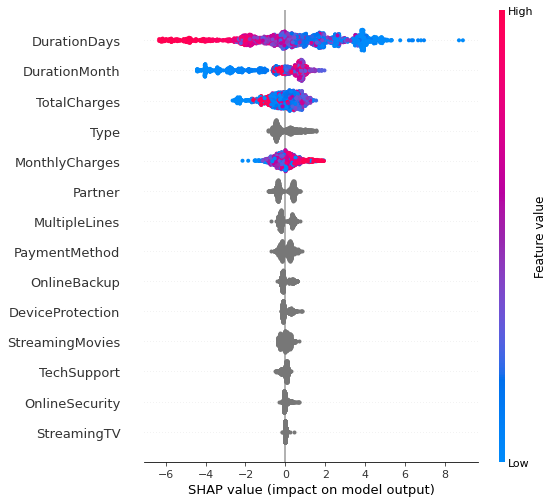

In [47]:
# Создаем объект TreeExplainer для SHAP с указанием категориальных признаков
explainer = shap.TreeExplainer(cat_model, feature_perturbation='tree_path_dependent')

# Получаем значения SHAP
shap_values = explainer.shap_values(features_test)

# График важности признаков
shap.summary_plot(shap_values, features_test, feature_names=features_test.columns);

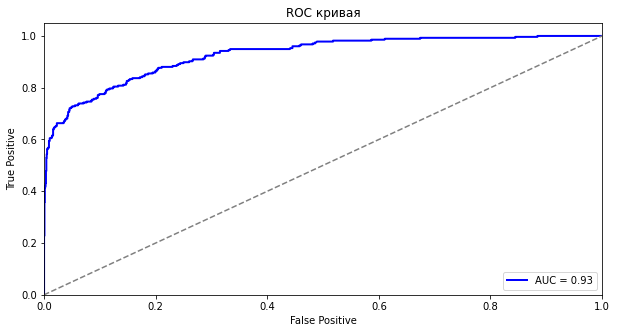

In [48]:
# Получим вероятности положительного класса
predicted_probs = cat_model.predict_proba(features_test)[:, 1]

# Вычислим ROC-кривую
fpr, tpr, thresholds = roc_curve(target_test, predicted_probs)
roc_auc = roc_auc_score(target_test, predicted_probs)

# Построим ROC-кривую
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC кривая')
plt.legend(loc='lower right')
plt.show()

### Вывод:
* Были рассмотрены модели: LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, CatBoostClassifier, SupportVectorClassifier
* Наиболее подходящей моделью для нашей задачи является CatBoostClassifier
* Mean AUC-ROC Score модели CatBoostClassifier на кросс-валидации составил 0.87, что является лучшим результатом среди выбранных моделей
* Лучшими параметрами были определены: 'depth': 3, 'iterations': 500, 'learning_rate': 0.3
* После обучения модели и проверки на тестовой выборке AUC-ROC Score составил 0.93, Accuracy - 0.92
* Самыми значимыми признаками для модели являются суммарная продолжительность дней и месяцев пользования клиента услугами, далее идут суммарные траты за весь период, тип подключения и ежемесячные платежи. 

# Отчёт   
##### 1. Проведена предобработка данных:     
* Явных дубликатов не обнаружено 
* Пропуски заменены на 'No'
* Добавлены новые столбцы: количество дней, месяцев
* Определён целевой признак - 'Leave'
##### 2. Выполнен исследовательский анализ:
* Самыми коррелирующими признаками оказались DurationDays(0.37), DurationMonth(0.37) и TotalCharges(0.3)
* Чем выше ежемесячная плата, чем больше клиентов уходит
* Чем больше клиент суммарно потратил денег на услуги, чем меньше вероятность ухода
* Больше всего уходов клиентов в районе 500 - 1500 дней, что соответствует середине гистограммы
* Чаще всего клиенты выбирают ежемесячную оплату, реже заключают договор за 2 года и за 1 год
##### 3. Применены методы машинного обучения с целью поиска клиентов, которые планируют уйти:
* Размер обучающей выборки составил - (5282, 14), тестовой - (1761, 14), соотношение 1 : 3
* Были рассмотрены модели: LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, CatBoostClassifier, SupportVectorClassifier
* Mean AUC-ROC Score модели CatBoostClassifier на кросс-валидации составил 0.87, что является лучшим результатом среди выбранных моделей
* Лучшими параметрами модели были определены: 'depth': 3, 'iterations': 500, 'learning_rate': 0.3, random_state=310723, class_weight = [1, 3]. 
* После обучения модели и проверки на тестовой выборке AUC-ROC Score составил 0.93, Accuracy - 0.92
* При обучении использовались следующие признаки: тип оплаты, способ оплаты, ежемесячные траты, суммарные траты, наличие возможности ведения параллельных линий во время звонка, тип подключения, онлайн-безопасность, возможность резервного копирования, защита девайсов, техническая поддержка, возможность просмотра ТВ и фильмов, наличие супруги(а). Также были сгенерированы следующие признаки: количество дней и месяцев пользования услугами.
* Самыми значимыми признаками для модели являются суммарная продолжительность дней и месяцев пользования клиента услугами, далее идут суммарные траты за весь период, тип подключения и ежемесячные платежи. 

#### Затруднения:
Просмотр корреляции всех признаков относительно целевого.   
Решение - использование библиотеки phik  

#### Ключевые шаги решения:
1. Предобработка данных:  
* В процессе предобработки данных пропущенные значения были заменены на 'No', а даты окончания продолжающихся договоров заменены на 1 февраля 2020, при этом в столбце Leave не возникло путанницы и замены всех значений на 1, которые говорят о конце договора
* Определение целевого признака - создание нового столбца (Leave)
* Создане столбцов с количеством дней и месяцев заключения договора
2. Машинное обучение:  
* Размер обучающей выборки составил - (5282, 14), тестовой - (1761, 14), соотношение 1 : 3
* Высокого значения метрики AUC-ROC помог достичь баланс классов модели CatBoostClassifier - 1:3, так как в данной задаче мы больше нацелены на поиск клиентов, планирующих уйти, нежели тех, кто планирует остаться
* Наиболее подходящей моделью для нашей задачи является CatBoostClassifier
* Mean AUC-ROC Score модели CatBoostClassifier на кросс-валидации составил 0.87, что является лучшим результатом среди выбранных моделей
* Лучшими параметрами модели были определены: 'depth': 3, 'iterations': 500, 'learning_rate': 0.3, random_state=310723, class_weight = [1, 3]   
* После обучения модели и проверки на тестовой выборке AUC-ROC Score составил 0.93, Accuracy - 0.92
* При обучении использовались следующие признаки: тип оплаты, способ оплаты, ежемесячные траты, суммарные траты, наличие возможности ведения параллельных линий во время звонка, тип подключения, онлайн-безопасность, возможность резервного копирования, защита девайсов, техническая поддержка, возможность просмотра ТВ и фильмов, наличие супруги(а). Также были сгенерированы следующие признаки: количество дней и месяцев пользования услугами.
* Самыми значимыми признаками для модели являются суммарная продолжительность дней и месяцев пользования клиента услугами, далее идут суммарные траты за весь период, тип подключения и ежемесячные платежи. 